In [1]:
import numpy as np
import pandas as pd
from collections import defaultdict
from scipy import stats
from config import config_dict
import os

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use('Cole_2018.mplstyle')

import neurodsp
from bycycle.features import compute_features

pd.options.display.max_columns=100

In [2]:
# Make directory for saving figures
if not os.path.exists('figs/s3'):
    os.makedirs('figs/s3')

In [3]:
df_shanks = pd.read_csv(config_dict['processed_path'] + 'df_shanks_stats.csv', index_col=0)
df_neus_raw = pd.read_csv(config_dict['processed_path'] + 'df_neus_stats.csv', index_col=0)
df_shapefr_corrs = pd.read_csv(config_dict['processed_path'] + 'df_fr_shape_corrs.csv', index_col=0)
df_shapespkt_corrs = pd.read_csv(config_dict['processed_path'] + 'df_spktime_shape_corrs.csv', index_col=0)
df_neus = df_neus_raw.merge(df_shapefr_corrs, on=['rat', 'sess', 'sh', 'clu'], how='outer')
df_neus = df_neus.merge(df_shapespkt_corrs, on=['rat', 'sess', 'sh', 'clu'], how='outer')
df_neus = df_neus[df_neus['N_spikes_burst0'] >= config_dict['analysis_N_spikes_min']]
df_neus.dropna(inplace=True)

In [4]:
df_shanks.head()

,rat,sess,sh,Fs,elec,burst_type,amp_mean,period_mean,rdsym_mean,ptsym_mean,cycling_frac,N_cycles_all,N_cycles_burst,N_seconds,corr_volt_amp_period_r,corr_volt_amp_period_p,corr_volt_amp_time_rdsym_r,corr_volt_amp_time_rdsym_p,corr_volt_amp_time_ptsym_r,corr_volt_amp_time_ptsym_p,corr_period_time_rdsym_r,corr_period_time_rdsym_p,corr_period_time_ptsym_r,corr_period_time_ptsym_p,corr_time_rdsym_time_ptsym_r,corr_time_rdsym_time_ptsym_p,mv_amp_mean,ms_period_mean
0,ec013,ec013.426,4,1250,0,0,2319.532520,161.287866,0.412290,0.414131,0.785563,11644,9362,1537.7272,-0.077456,6.156500e-14,0.040812,7.814688e-05,-0.056677,4.075107e-08,-0.078357,3.143550e-14,0.068883,2.523349e-11,-0.069632,1.533282e-11,2.319533,129.030293
1,ec013,ec013.426,4,1250,0,1,2506.020471,159.755894,0.413762,0.416971,0.229142,11644,2757,1537.7272,-0.045395,1.714016e-02,0.074978,8.125541e-05,-0.005567,7.701624e-01,-0.139330,2.006159e-13,0.089944,2.243371e-06,-0.078136,4.006003e-05,2.506020,127.804715
2,ec013,ec013.426,4,1250,0,2,2294.748565,162.577416,0.417008,0.418010,0.857648,11644,10140,1537.7272,-0.074177,7.498704e-14,0.022376,2.424323e-02,-0.069449,2.542994e-12,-0.053720,6.206877e-08,0.062979,2.190056e-10,-0.062067,3.969768e-10,2.294749,130.061933
3,ec013,ec013.426,4,1250,0,3,2596.327103,156.988942,0.434752,0.428598,0.051699,11644,633,1537.7272,0.047954,2.282801e-01,0.045272,2.553896e-01,0.083773,3.509748e-02,-0.073497,6.460276e-02,-0.005631,8.875558e-01,0.026173,5.109850e-01,2.596327,125.591153
4,ec013,ec013.426,5,1250,0,0,2200.710141,161.099577,0.412755,0.419072,0.773503,11619,9229,1537.7200,-0.068670,4.006313e-11,0.062534,1.825662e-09,-0.043223,3.271105e-05,-0.082509,2.039848e-15,0.070847,9.510113e-12,-0.067264,9.909330e-11,2.200710,128.879662


In [5]:
df_neus.head()

,rat,sess,sh,clu,fr1,fr2,type,fr_recording,N_spikes_recording,fr_burst0,fr_notburst0,N_spikes_burst0,mwu_fr_burst0_notburst_p,fr_burst1,fr_notburst1,N_spikes_burst1,mwu_fr_burst1_notburst_p,fr_burst2,fr_notburst2,N_spikes_burst2,mwu_fr_burst2_notburst_p,fr_burst3,fr_notburst3,N_spikes_burst3,mwu_fr_burst3_notburst_p,sfc_magnitude_recording,sfc_phase_recording,sfc_magnitude_cycles,sfc_phase_cycles,sfc_magnitude_cycles_hilbert,sfc_phase_cycles_hilbert,norm_fr_diff_burst0,norm_fr_diff_burst1,norm_fr_diff_burst2,norm_fr_diff_burst3,sfc_phase_cycles_2pi,burst_type,corr_cycle_fr_volt_amp_r,corr_cycle_fr_volt_amp_p,corr_cycle_fr_period_r,corr_cycle_fr_period_p,corr_cycle_fr_time_rdsym_r,corr_cycle_fr_time_rdsym_p,corr_cycle_fr_time_ptsym_r,corr_cycle_fr_time_ptsym_p,corr_burst_across_fr_volt_amp_r,corr_burst_across_fr_volt_amp_p,corr_burst_within_fr_volt_amp_avgr,corr_burst_within_fr_volt_amp_p,corr_burst_across_fr_period_r,corr_burst_across_fr_period_p,corr_burst_within_fr_period_avgr,corr_burst_within_fr_period_p,corr_burst_across_fr_time_rdsym_r,corr_burst_across_fr_time_rdsym_p,corr_burst_within_fr_time_rdsym_avgr,corr_burst_within_fr_time_rdsym_p,corr_burst_across_fr_time_ptsym_r,corr_burst_across_fr_time_ptsym_p,corr_burst_within_fr_time_ptsym_avgr,corr_burst_within_fr_time_ptsym_p,glm_cycle_fr_coef_volt_amp,glm_cycle_fr_p_volt_amp,glm_cycle_fr_coef_period,glm_cycle_fr_p_period,glm_cycle_fr_coef_time_rdsym,glm_cycle_fr_p_time_rdsym,glm_cycle_fr_coef_time_ptsym,glm_cycle_fr_p_time_ptsym,glm_cycle_fr_r2,glm_burst_fr_coef_volt_amp,glm_burst_fr_p_volt_amp,glm_burst_fr_coef_period,glm_burst_fr_p_period,glm_burst_fr_coef_time_rdsym,glm_burst_fr_p_time_rdsym,glm_burst_fr_coef_time_ptsym,glm_burst_fr_p_time_ptsym,glm_burst_fr_r2,glm_speed_fr_coef_volt_amp,glm_speed_fr_p_volt_amp,glm_speed_fr_coef_period,glm_speed_fr_p_period,glm_speed_fr_coef_time_rdsym,glm_speed_fr_p_time_rdsym,glm_speed_fr_coef_time_ptsym,glm_speed_fr_p_time_ptsym,glm_speed_fr_coef_speed,glm_speed_fr_p_speed,glm_speed_fr_r2,nonuniform_norm_spk_times_D,nonuniform_norm_spk_times_p,mwu_normtime_rdsym_p,norm_spktime_asym_mode,norm_spktime_sym_mode,mwu_trough_time_rdsym_p,trough_spike_asym_mode,trough_spike_sym_mode,pha_spike_asym_mode,pha_spike_sym_mode
353,ec014,ec014.183,0,2,2.926401,3.205607,i,0.403591,1552,0.312845,0.596378,818,7.989087e-15,0.142209,0.488426,134,1.456699e-23,0.344282,0.615111,1034,5.531508e-11,0.060265,0.432503,18,6.727093e-10,0.385240,2.774214,0.336951,2.587782,0.358574,2.484881,-0.311841,-0.548997,-0.282292,-0.755401,2.587782,0.0,0.004023,5.585713e-01,0.071948,1.109274e-25,0.023484,0.000636,0.000892,8.967401e-01,0.036080,0.096128,-0.006075,0.909968,0.061915,0.004274,0.200039,2.693972e-09,0.016313,4.519691e-01,0.139926,0.000643,0.036468,9.259766e-02,-0.100383,0.003559,0.062672,0.002055,0.115789,1.143620e-08,0.110703,5.873277e-08,0.038091,6.237815e-02,0.003342,0.065021,0.101063,0.079405,0.060777,0.039104,3.187653e-01,0.038355,3.572393e-01,0.004342,0.048864,0.210277,0.074989,0.065383,-0.005552,0.882699,0.052189,1.896668e-01,-0.015216,0.682671,0.178592,0.123576,2.403455e-11,4.071474e-25,0.675,0.225,1.470524e-08,-0.005,-0.005,2.984513,2.670354
354,ec014,ec014.183,0,2,2.926401,3.205607,i,0.403591,1552,0.312845,0.596378,818,7.989087e-15,0.142209,0.488426,134,1.456699e-23,0.344282,0.615111,1034,5.531508e-11,0.060265,0.432503,18,6.727093e-10,0.385240,2.774214,0.336951,2.587782,0.358574,2.484881,-0.311841,-0.548997,-0.282292,-0.755401,2.587782,1.0,0.018592,9.937228e-02,0.022183,4.927189e-02,0.005341,0.635946,0.029103,9.884414e-03,0.001853,0.938852,0.206924,0.047493,-0.007400,0.759368,0.145811,1.792429e-01,0.006022,8.031553e-01,0.123510,0.302126,0.049385,4.080445e-02,0.114410,0.350505,0.061457,0.017118,0.012276,6.331106e-01,0.021876,3.963451e-01,0.082282,1.490570e-03,0.001891,-0.002881,0.927883,-0.037679,0.244593,-0.011687,7.019540e-01,0.050664,1.178584e-01,0.002032,0.010495,0.746578,-0.011253,0.735990,-0.014146,0.649973,0.064759,4.714902e-02,0.104001,0.00104

# A-C. simulate neural signal

In [6]:
from scipy import signal
np.random.seed(0)

def simfiltonef(T, f_range, Fs, N):
    """ Simulate a band-pass filtered signal with 1/f^2 
    Input suggestions: f_range=(2,None), Fs=1000, N=1000
    
    Parameters
    ----------
    T : float
        length of time of simulated oscillation
    Fs : float
        oscillation sampling rate
    f_range : 2-element array (lo,hi)
        frequency range of simulated data
        if None: do not filter
    N : int
        order of filter
    """

    if f_range is None:
        # Do not filter
        # Generate 1/f^2 noise
        brownN = simbrown(int(T*Fs))
        return brownN
    elif f_range[1] is None:
        # Make filter order odd if necessary
        nyq = Fs / 2.
        if N % 2 == 0:
            print('NOTE: Increased high-pass filter order by 1 in order to be odd')
            N += 1
            
        # Generate 1/f^2 noise
        brownN = simbrown(int(T*Fs+N*2))

        # High pass filter
        taps = signal.firwin(N, f_range[0] / nyq, pass_zero=False)
        brownNf = signal.filtfilt(taps, [1], brownN)
        return brownNf[N:-N]

    else:
        # Bandpass filter
        # Generate 1/f^2 noise
        brownN = simbrown(int(T*Fs+N*2))
        # Filter
        nyq = Fs / 2.
        taps = signal.firwin(N, np.array(f_range) / nyq, pass_zero=False)
        brownNf = signal.filtfilt(taps, [1], brownN)
        return brownNf[N:-N]
    

def simbrown(N):
    """Simulate a brown noise signal (power law distribution 1/f^2)
    with N samples"""
    wn = np.random.randn(N)
    return np.cumsum(wn)
    

def norm01(x):
    return (x - np.min(x))/(np.max(x)-np.min(x))

In [7]:
# Simulate sawtooth wave
# use rdsym from first recording
rdsym, period, Fs_record = df_shanks.loc[0, ['rdsym_mean', 'period_mean', 'Fs']]
Fs = 1000
N_cycles = 50000

period_ms = np.round(period/Fs_record*Fs)
rise_ms = np.round(period_ms * rdsym)
decay_ms = period_ms - rise_ms

pha_one_cycle = np.hstack([np.linspace(0, np.pi, decay_ms+1), np.linspace(-np.pi, 0, rise_ms+1)[1:-1]])
phase_t = np.tile(pha_one_cycle, N_cycles)
x_sawtooth = np.cos(phase_t)
t = np.arange(0, len(x_sawtooth)/Fs, 1/Fs)

# Add brown noise to sawtooth wave
T = len(phase_t) / Fs
f_range = (2, None)
N = 1000
x_brown = simfiltonef(T, f_range, Fs, N)

# Normalize brown noise power
sawtooth_power = np.mean(x_sawtooth**2)
brown_power = np.mean(x_brown**2)
power_ratio = .2 # Higher power ratio is more noise
x_brown = np.sqrt(x_brown**2 * power_ratio * sawtooth_power / brown_power) * np.sign(x_brown)

# Combine signals
x = x_sawtooth + x_brown

/Users/scott/anaconda/envs/shapyspiky/lib/python3.6/site-packages/ipykernel_launcher.py:11: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  # This is added back by InteractiveShellApp.init_path()


NOTE: Increased high-pass filter order by 1 in order to be odd


/Users/scott/anaconda/envs/shapyspiky/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/Users/scott/anaconda/envs/shapyspiky/lib/python3.6/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/Users/scott/anaconda/envs/shapyspiky/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of

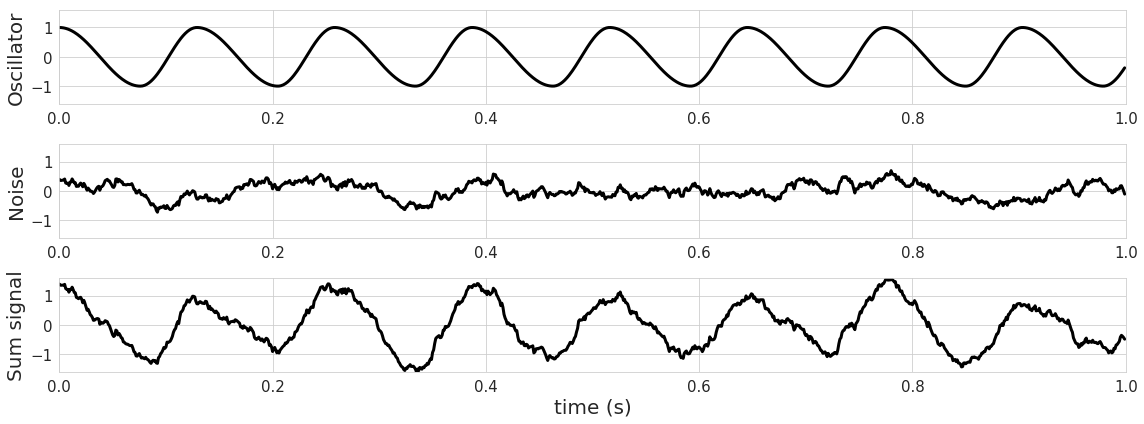

In [8]:
tlim = (0,1)
tidx = np.logical_and(t>=tlim[0], t<tlim[1])

plt.figure(figsize=(16,6))
plt.subplot(3,1,1)
plt.plot(t[tidx], x_sawtooth[tidx], 'k', linewidth=3)
plt.ylabel('Oscillator')
plt.xlim((0,1))
plt.ylim((-1.6,1.6))
plt.subplot(3,1,2)
plt.plot(t[tidx], x_brown[tidx], 'k', linewidth=3)
plt.ylabel('Noise')
plt.xlim((0,1))
plt.ylim((-1.6,1.6))
plt.subplot(3,1,3)
plt.plot(t[tidx], x[tidx], 'k', linewidth=3)
plt.ylabel('Sum signal')
plt.xlabel('time (s)')
plt.xlim((0,1))
plt.ylim((-1.6,1.6))

plt.tight_layout()
plt.savefig('figs/s3/ABC.png')

# Simulate neuron with SFC
* Coupled to end of decay (like interneuron)

In [9]:
np.random.seed(0)

def pha_to_fr(pha, mu, std):
    pha_diff = np.angle(np.exp(1j*(pha - mu)))
    return np.exp(-pha_diff**2 / (2 * std**2))

# Compute probability of a spike at each point in time
neu_fr = 30
neu_prefpha = 3/4*np.pi
# neu_prefstd = np.pi/4
neu_prefstd = np.pi/2
spk_prob_t = pha_to_fr(phase_t, neu_prefpha, neu_prefstd)
N_seconds = len(spk_prob_t)/Fs
spk_prob_t = spk_prob_t / (np.sum(spk_prob_t)/N_seconds) * neu_fr

# Determine spike times
spike_bool = spk_prob_t > np.random.rand(len(spk_prob_t))
spike_times = np.where(spike_bool)[0]

# Compute cycle features

In [10]:
def compute_shape(lfp, Fs, f_range, cf_low, cf_high, N_seconds_low, N_seconds_high,
                  hilbert_increase_N=False):
    """Compute shape features on a cycle-by-cycle basis"""

    # Make lfp values floats if not already
    lfp = lfp.astype(float)

    # Lowpass and highpass filter LFP
    lfp = neurodsp.filter(lfp, Fs, 'lowpass', cf_low,
                          N_seconds=N_seconds_low, remove_edge_artifacts=False)
    lfp = neurodsp.filter(lfp, Fs, 'highpass', cf_high,
                          N_seconds=N_seconds_high, remove_edge_artifacts=False)

    # Set parameters for defining oscillatory bursts
    osc_kwargs = config_dict['burst_kwargs_list'][0]

    # Calculate shape features
    df = compute_features(lfp, Fs, f_range,
                     center_extrema=config_dict['extrema_center'],
                     hilbert_increase_N=hilbert_increase_N,
                     burst_detection_kwargs=osc_kwargs)

    return lfp, df

In [11]:
x_filt, df_shape = compute_shape(x, Fs, config_dict['f_range'],
                                     config_dict['cf_low'], config_dict['cf_high'],
                                     config_dict['N_seconds_low'], config_dict['N_seconds_high'])            

Transition bandwidth is 2.9 Hz. Pass/stop bandwidth is 25 Hz
Transition bandwidth is 1.0 Hz. Pass/stop bandwidth is 499.0 Hz


# D. More asymmetric ~ later normalized spike time

In [12]:
# Determine spikes that occurred in each cycle
cycle_spikes = []
for i, row in df_shape.iterrows():
    cycle_spikes.append(spike_times[np.logical_and(spike_times >= row['sample_last_peak'],
                                                   spike_times < row['sample_next_peak'])])

# Compute FR for each cycle    
df_shape['spikes'] = cycle_spikes
df_shape['N_spikes'] = df_shape['spikes'].str.len()
df_shape['fr'] = df_shape['N_spikes'] / (df_shape['period'] / Fs)

def normalize_spikes(row):
    return (np.array(row['spikes']) - row['sample_last_peak']) / row['period']
    
spike_samples_temp = []
for i_cycle, row_cycle in df_shape.iterrows():
    spike_samples_temp.append(normalize_spikes(row_cycle))
df_shape['spikes_norm'] = spike_samples_temp

/Users/scott/anaconda/envs/shapyspiky/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


MannwhitneyuResult(statistic=3106970913.5, pvalue=2.1797000461989834e-24)


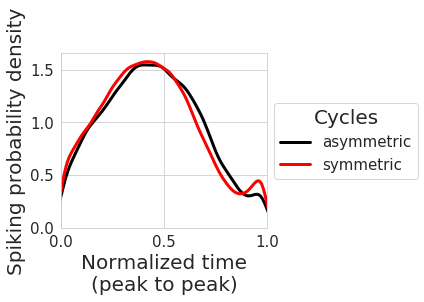

In [13]:
# Compare spikes for most asymmetric and most symmetric cycles
df_asym = df_shape[df_shape['time_rdsym'] < .4]
spikes_norm_asym = [x for y in df_asym['spikes_norm'] for x in y]
df_sym = df_shape[df_shape['time_rdsym'] > .4]
spikes_norm_sym = [x for y in df_sym['spikes_norm'] for x in y]

plt.figure(figsize=(6,4))
sns.distplot(spikes_norm_asym, bins=np.arange(0, 1.05, .05), label='asymmetric', color='k', hist=False,
             kde_kws={'linewidth':3})
sns.distplot(spikes_norm_sym, bins=np.arange(0, 1.05, .05), label='symmetric', color='r', hist=False,
             kde_kws={'linewidth':3})

legend = plt.legend(fontsize=15, loc='center left',
                    bbox_to_anchor=(1, 0.5), title='Cycles')
legend.get_title().set_fontsize('20')
plt.xlim((0,1))
plt.xlabel('Normalized time\n(peak to peak)')
plt.ylabel('Spiking probability density')
plt.xticks([0,.5,1])
plt.yticks(np.arange(0,1.6,.5))
plt.tight_layout()
plt.savefig('figs/s3/D.png')

print(stats.mannwhitneyu(spikes_norm_asym, spikes_norm_sym))

# E. More Asymmetric: earlier trough-locked spike time

In [14]:
# Get spikes around each trough
cycle_spikes = []
for i, row in df_shape.iterrows():
    cycle_spikes.append(spike_times[np.logical_and(spike_times >= row['sample_trough'] - 70,
                                                   spike_times < row['sample_trough'] + 70)] - row['sample_trough'])
df_shape['spikes_trough'] = cycle_spikes

MannwhitneyuResult(statistic=3475909427.5, pvalue=4.287384879351395e-68)


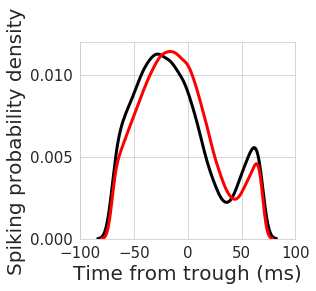

In [15]:
# Compare spikes for most asymmetric and most symmetric cycles
df_asym = df_shape[df_shape['time_rdsym'] < .4]
df_sym = df_shape[df_shape['time_rdsym'] > .4]
spikes_trough_asym = [x for y in df_asym['spikes_trough'] for x in y]
spikes_trough_sym = [x for y in df_sym['spikes_trough'] for x in y]

plt.figure(figsize=(4.5,4))
sns.distplot(spikes_trough_asym, bins=np.arange(-100, 105, 5), color='k', hist=False,
             kde_kws={'linewidth':3})
sns.distplot(spikes_trough_sym, bins=np.arange(-100, 105, 5), color='r', hist=False,
             kde_kws={'linewidth':3})
plt.xlim((-100, 100))
plt.xlabel('Time from trough (ms)')
plt.ylabel('Spiking probability density')
plt.yticks(np.arange(0,.016,.005))
plt.ylim((0,.012))
plt.tight_layout()
plt.savefig('figs/s3/E.png')

print(stats.mannwhitneyu(spikes_trough_asym, spikes_trough_sym))

# F. More asymmetric: Firing more at earlier phases

In [16]:
# Compute phase at each point in time
from bycycle.cyclepoints import extrema_interpolated_phase
Ps = np.append(df_shape['sample_last_peak'].values, df_shape['sample_next_peak'].values[-1])
pha = extrema_interpolated_phase(x, Ps, df_shape['sample_trough'],
                                 zeroxR=df_shape['sample_zerox_rise'],
                                 zeroxD=df_shape['sample_zerox_decay'])

# Determine phase of each spike in each cycle
spike_phases = []
for i, row in df_shape.iterrows():
    spike_phases.append(pha[row['spikes']])
df_shape['spike_phases'] = spike_phases

In [17]:
# Determine phase array for each cycle
cycle_phases = []
for i, row in df_shape.iterrows():
    cycle_phases.append(pha[row['sample_last_peak']:row['sample_next_peak']])
df_shape['cycle_phases'] = cycle_phases

In [18]:
# Make histograms of firing rates for asym and sym
pha_bins = np.arange(-np.pi, np.pi*1.05, np.pi*.05)

df_asym = df_shape[df_shape['time_rdsym'] < .4]
df_sym = df_shape[df_shape['time_rdsym'] > .4]

all_spikes_pha_asym = [x for y in df_asym['spike_phases'] for x in y]
all_pha_asym = [x for y in df_asym['cycle_phases'] for x in y]
pha_bins_Nsamples_asym, _ = np.histogram(all_pha_asym, bins=pha_bins)
hist_asym, _ = np.histogram(all_spikes_pha_asym, bins=pha_bins)
hist_asym = hist_asym / pha_bins_Nsamples_asym

all_spikes_pha_sym = [x for y in df_sym['spike_phases'] for x in y]
all_pha_sym = [x for y in df_sym['cycle_phases'] for x in y]
pha_bins_Nsamples_sym, _ = np.histogram(all_pha_sym, bins=pha_bins)
hist_sym, _ = np.histogram(all_spikes_pha_sym, bins=pha_bins)
hist_sym = hist_sym / pha_bins_Nsamples_sym

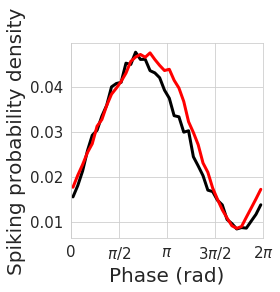

In [19]:
# Convert phase to 0 to 2pi
pha_bin_mid = [np.mean([x,y]) for (x,y) in zip(pha_bins[:-1], pha_bins[1:])]
pha_bin_mid2 = [p if p > 0 else 2*np.pi+p for p in pha_bin_mid]
plt.figure(figsize=(4,4))
plt.plot(np.roll(pha_bin_mid2,-20), np.roll(hist_asym, -20),color='k', linewidth=3)
plt.plot(np.roll(pha_bin_mid2,-20), np.roll(hist_sym, -20), color='r', linewidth=3)
plt.xticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi], [0, '$\pi/2$', '$\pi$', '$3\pi/2$', '$2\pi$'])
plt.xlim((0, 2*np.pi))
plt.xlabel('Phase (rad)')
plt.ylabel('Spiking probability density')
plt.tight_layout()
plt.savefig('figs/s3/F.png')